In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Defined functions
# NA check
def findnanrows(df):
    is_NaN = df.isnull() 
    row_has_NaN = is_NaN.any(axis=1) 
    rows_with_NaN = df[row_has_NaN] 
    return rows_with_NaN

# missing 
def interpolatedata(df):
    filldf = df.groupby(pd.Grouper(freq='10T')).mean()
    dfnan = findnanrows(filldf)
    print("==> %s rows have been filled <==" %len(dfnan))
    filldf = filldf.interpolate().round(2)
    return filldf

# load data
def loaddata(sartyear, endyear):
    urlpath = 'https://www.bgc-jena.mpg.de/wetter/'
    urllist = []
    df = pd.DataFrame()
    for year in np.arange(sartyear, endyear, 1):
        urllist.append(urlpath+"mpi_roof_"+str(year)+"a.zip")
        urllist.append(urlpath+"mpi_roof_"+str(year)+"b.zip")
    for url in urllist:
        df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
    df.index.name = 'datetime'
    return df

#ACF
def cal_ACF(y, lag, sample_plot_name):
    mean = np.mean(y)
    D = sum((y-mean)**2)
    R = []
    for tao in range(lag+1):
        S = 0
        for t in range(tao, len(y)):
            N = (y[t]-mean)*(y[t-tao]-mean)
            S += N
        r = S/D
        R.append(r)
    R_inv = R[::-1]
    Magnitute = R_inv + R[1:]
    ax = plt.figure()
    x_values = range(-lag, lag + 1)
    (markers, stemlines, baseline) = plt.stem(x_values, Magnitute, markerfmt='o')
    plt.setp(markers, color = 'red')
    m = 1.96/np.sqrt(len(y))
    plt.axhspan(-m, m, alpha = 0.2, color = 'blue')
    plt.xlabel('Lags')
    plt.ylabel('Magnitute')
    plt.title(f'Autocorrelation Function of {sample_plot_name}' )
    plt.show()
    return ax

In [20]:
raw_data = loaddata(sartyear=2019, endyear=2021)

/var/folders/fq/s6_sst4x3cv_zj9lkplg7f640000gn/T/ipykernel_45941/1813278560.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
/var/folders/fq/s6_sst4x3cv_zj9lkplg7f640000gn/T/ipykernel_45941/1813278560.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
/var/folders/fq/s6_sst4x3cv_zj9lkplg7f640000gn/T/ipykernel_45941/1813278560.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
/var/folders/fq/s6_sst4x3cv_zj9lkplg7f64000

In [21]:
#raw_data = pd.read_csv("raw_dataset.csv")

In [22]:
# raw dataset 
print(f"Shape of raw dataset: {raw_data.shape}")
print(f"NA in the raw dataset: {findnanrows(raw_data)}")
# save the raw dataset 
raw_data.to_csv("raw_dataset.csv")

Shape of raw dataset: (105256, 21)
NA in the raw dataset: Empty DataFrame
Columns: [p (mbar), T (degC), Tpot (K), Tdew (degC), rh (%), VPmax (mbar), VPact (mbar), VPdef (mbar), sh (g/kg), H2OC (mmol/mol), rho (g/m**3), wv (m/s), max. wv (m/s), wd (deg), rain (mm), raining (s), SWDR (W/m²), PAR (µmol/m²/s), max. PAR (µmol/m²/s), Tlog (degC), CO2 (ppm)]
Index: []

[0 rows x 21 columns]


In [23]:
# Missing observations
df = interpolatedata(raw_data)
#print(df.shape)

==> 9 rows have been filled <==


In [25]:
#change date format, remove index
date_range = pd.date_range(start="2019-01-01 00:10:00", end="2021-01-01 00:00:00", freq="10T")
df.insert(0, "date", date_range)
df = df.reset_index()
df = df.iloc[:, 1:]
df = df.set_index('date')
hourly_df = df.resample("60T").mean()
print(f"Hourly_df shape {hourly_df.shape}")

Hourly_df shape (17545, 21)


In [26]:
# Target varibale statistics
hourly_df["wv (m/s)"].describe()

count    17545.000000
mean         2.042032
std         12.676319
min      -1664.906667
25%          1.015000
50%          1.750000
75%          2.795000
max         13.215000
Name: wv (m/s), dtype: float64

In [27]:
# Outlier - change the minimum to mean
mean_wind = hourly_df["wv (m/s)"].mean()
min_wind = hourly_df["wv (m/s)"].min()
hourly_df["wv (m/s)"] = hourly_df["wv (m/s)"].replace(min_wind, mean_wind)
hourly_df = hourly_df.reset_index()

In [ ]:
#hourly_df.to_csv("hourly_df.csv", index = False)

##### Start to clean 

In [5]:
df = pd.read_csv("hourly_df.csv")
print(f"df shape: {df.shape}")

df shape: (26305, 22)


In [4]:
df.columns

Index(['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)',
       'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)', 'CO2 (ppm)'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


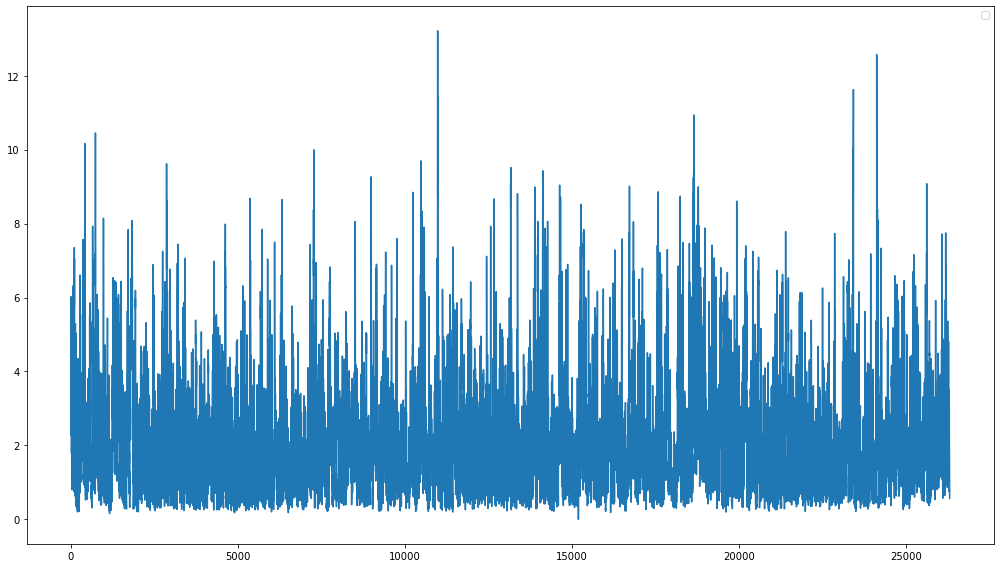

In [8]:
plt.figure(figsize=(14, 8))
plt.plot( df["wv (m/s)"])
plt.legend()
plt.tight_layout()
plt.show()